# Crime Analysis

## Imports

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.types import *
from pyspark.sql.functions import input_file_name, regexp_extract
import pyspark.sql.functions as sql_f
import pyspark.sql.functions as F
from pyspark.sql.functions import sha2, concat_ws
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum, when, trim
import numpy as np


In [25]:
spark = SparkSession.builder \
    .appName("London Crime Analysis") \
    .getOrCreate()

schema = StructType([
    StructField("Crime ID", StringType(), True),
    StructField("Month", StringType(), True),
    StructField("Reported by", StringType(), True),
    StructField("Falls within", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("LSOA code", StringType(), True),
    StructField("LSOA name", StringType(), True),
    StructField("Crime type", StringType(), True),
    StructField("Last outcome category", StringType(), True),
    StructField("Context", StringType(), True),
])

df = spark.read.option("header", True).schema(schema).csv("/home/alumno/reposirotio/Grupo4/*/*.csv")

# Normalize column names
def normalize(col):
    return (
        col.lower()
           .replace(" ", "_")
           .replace("-", "_")
    )

df = df.select([
    df[c].alias(normalize(c)) for c in df.columns
])

# Convert 'month' column to 'year' and 'month_num'
df = (
    df
    .withColumn("month_date", sql_f.to_date(sql_f.col("month"), "yyyy-MM"))
    .withColumn("year", sql_f.year("month_date"))
    .withColumn("month_num", sql_f.month("month_date"))
)

26/01/07 09:17:21 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /home/alumno/reposirotio/Grupo4/*/*.csv.
java.io.FileNotFoundException: File /home/alumno/reposirotio/Grupo4/*/*.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.s

In [26]:
# Row filtering, explained below
df_clean = df.filter(
    sql_f.col("latitude").isNotNull() &
    sql_f.col("longitude").isNotNull() &
    sql_f.col("lsoa_name").isNotNull()
).select(
    "month",
    "longitude",
    "latitude",
    "crime_type",
    "falls_within",
    "lsoa_name",
    "year",
    "month_num"
)

df_clean.cache()
df_clean.count()

26/01/07 09:17:29 WARN CacheManager: Asked to cache already cached data.


17335882

## Analysis

### Column Values

Below we analyse the data of each column of our DataFrame. From this analysis we can get the following information to start working with our data:
 - **Row Count**: The dataset is composed of 18045723 rows.
 - **crime_id**: Long string ID representing the crime report. Not all reports have the ID
 - **reported_by**: Which territorial police force reported the crime. There are 44 values
 - **falls_within**: Which territorial police force has to manage the crime.
 - **longitude, latitude**: Coordinates of the reported crime. Has missing values.
 - **location**: Small description of the location of the crime.
 - **lsoa_code, lsoa_name**: *Lower layer Super Output Area* code and name. Has missing valus.
 - **crime_type**: Classification of the types of crime. 14 types are listed.
 - **last_outcome_category**: Status report of the crime.
 - **context**: Always NULL value.

We will keep rows with null crime_id, since the rest of the information might be valid. We WILL remove all rows with null coordinates or LSOA code/name, since that information is crucial for the analysis and model training.


In [11]:
# Count of missing values per column
missing_counts = (
    df.select([
        sum(
            when(col(c).isNull() | (trim(col(c)) == ""), 1).otherwise(0)
        ).alias(c)
        for c in df.columns
    ])
)

missing_counts.show(truncate=False)

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+----------+----+---------+
|crime_id|month|reported_by|falls_within|longitude|latitude|location|lsoa_code|lsoa_name|crime_type|last_outcome_category|context |month_date|year|month_num|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+----------+----+---------+
|2960255 |0    |0          |0           |278702   |278702  |0       |709841   |709841   |0         |3257830              |18045723|0         |0   |0        |
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+----------+----+---------+



In [12]:
# Count of unique values per column
unique_counts = df.select([
    F.countDistinct(F.col(c)).alias(c) for c in df.columns
])

unique_counts.show(truncate=False)

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----------+----+---------+
|crime_id|month|reported_by|falls_within|longitude|latitude|location|lsoa_code|lsoa_name|crime_type|last_outcome_category|context|month_date|year|month_num|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----------+----+---------+
|14708731|36   |44         |44          |692137   |671430  |282913  |35764    |37885    |14        |15                   |0      |36        |4   |12       |
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----------+----+---------+



### Data Analysis

Lets start plotting the crime rates by year and month, to get an overview of the trend year-round

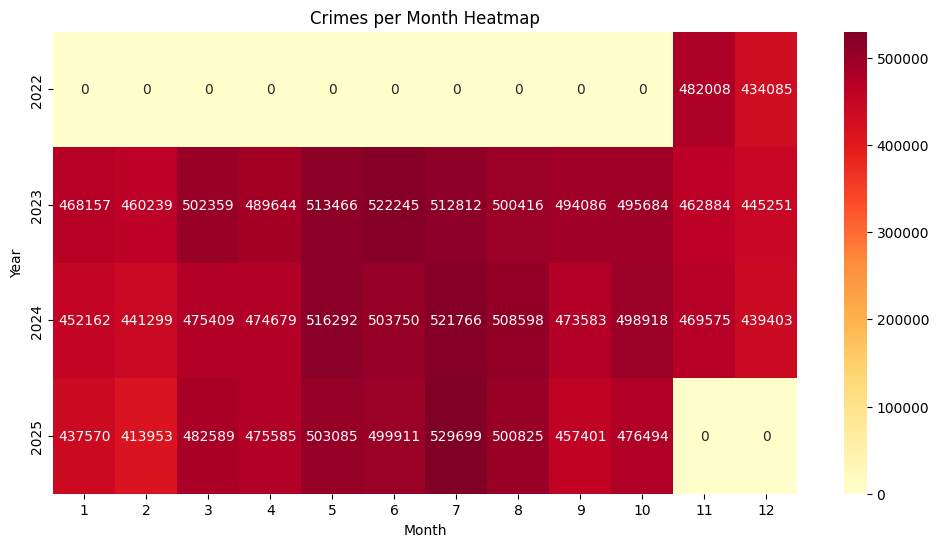

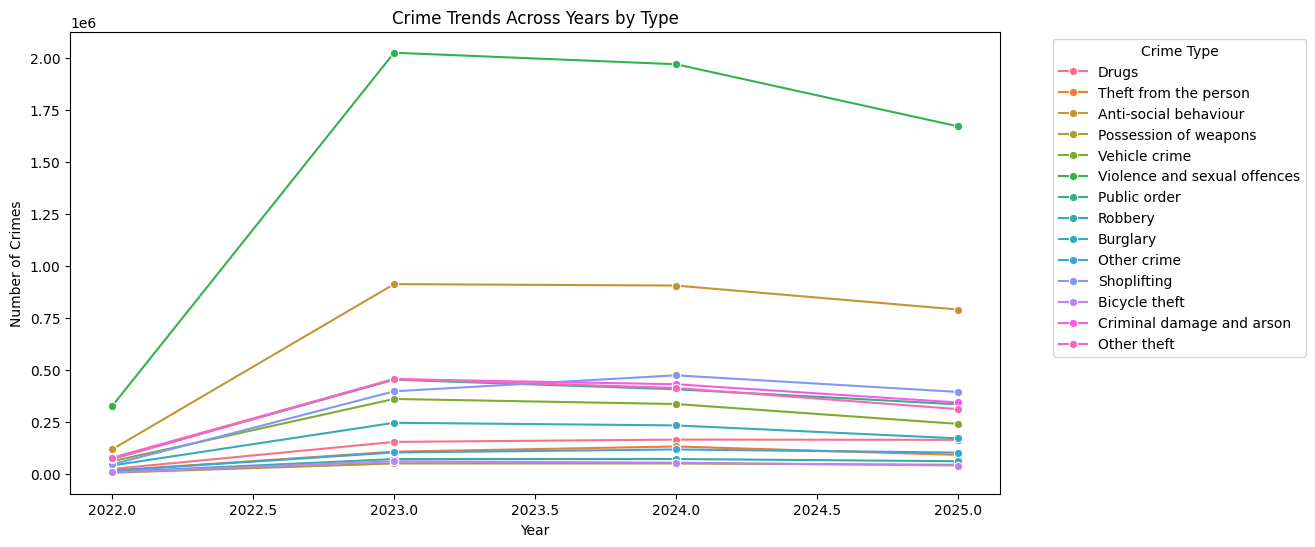

In [25]:
# 1. Aggregate total crimes per month and year
monthly_counts_df = (
    df_clean.groupBy("year", "month_num")
      .agg(sql_f.count("*").alias("crime_count"))
      .orderBy("year", "month_num")
)

monthly_counts_pd = monthly_counts_df.toPandas()

# Pivot to make heatmap friendly (rows=year, columns=month)
heatmap_data = monthly_counts_pd.pivot(index="year", columns="month_num", values="crime_count").fillna(0)

# 2. Plot heatmap of crimes per month/year
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Crimes per Month Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# 3. Trend across years per crime type
trend_df = (
    df_clean.groupBy("year", "crime_type")
      .agg(sql_f.count("*").alias("crime_count"))
      .orderBy("year")
)

trend_pd = trend_df.toPandas()

# Lineplot for trend
plt.figure(figsize=(12,6))
sns.lineplot(data=trend_pd, x="year", y="crime_count", hue="crime_type", marker="o")
plt.title("Crime Trends Across Years by Type")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

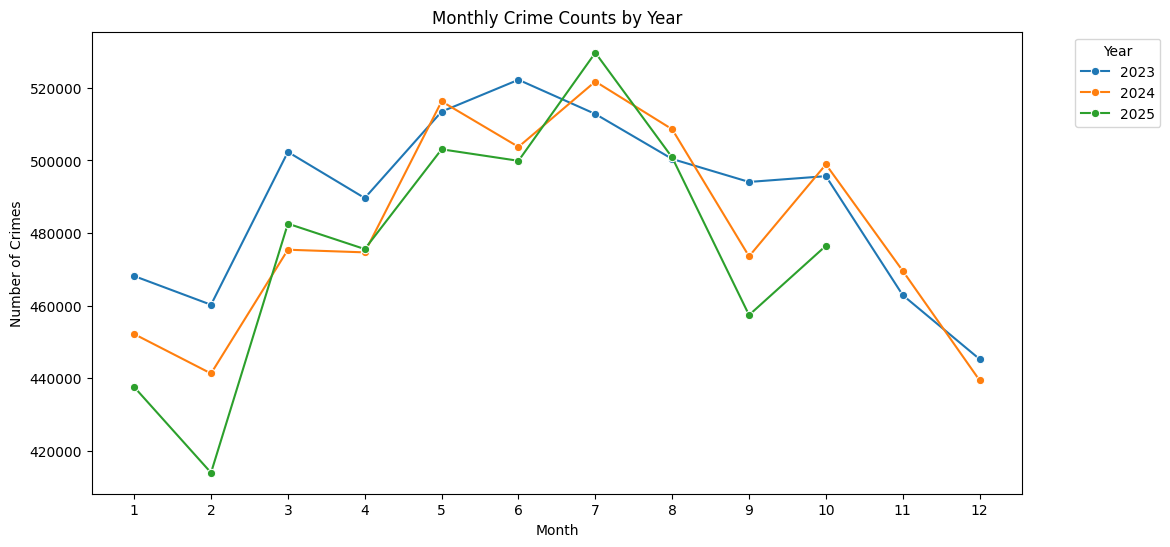

In [26]:
monthly_counts_pd = monthly_counts_df.toPandas()

monthly_counts_pd = monthly_counts_pd.sort_values(["year", "month_num"])
monthly_counts_pd = monthly_counts_pd[monthly_counts_pd.year != 2022]

# Line plot: one line per year, months on x-axis
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_counts_pd,
    x="month_num",
    y="crime_count",
    hue="year",
    marker="o",
    palette="tab10"
)
plt.title("Monthly Crime Counts by Year")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.xticks(range(1,13))  # Ensure all months 1-12 are shown
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

   year  crime_count
0  2023      5177185
1  2024      5057092
2  2025      4966115


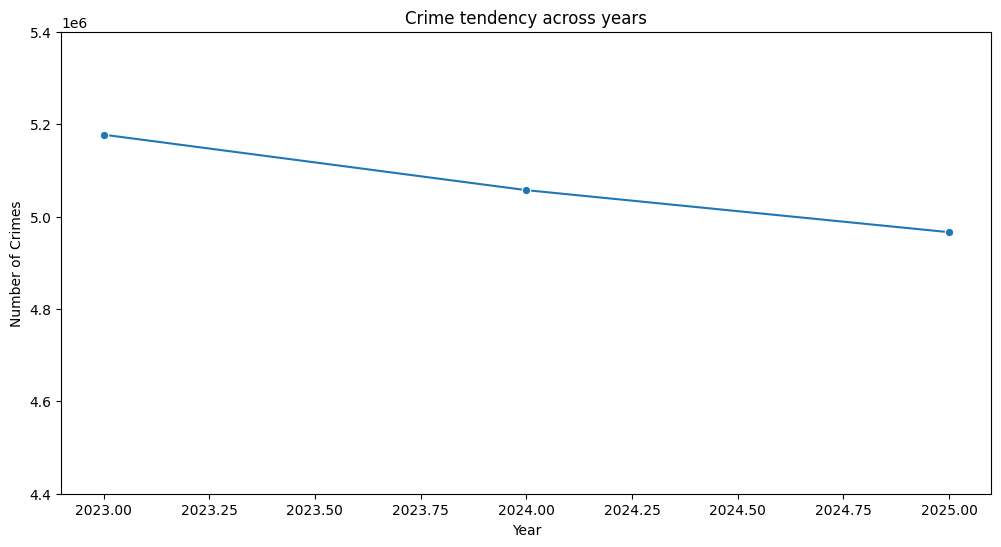

In [28]:
crimes_per_year = df.filter("year > 2022").filter("month_num < 11")\
            .groupBy("year")\
            .agg(sql_f.count("*").alias("crime_count"))\
            .orderBy("year")\
            .toPandas()

print(crimes_per_year)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=crimes_per_year,
    x="year",
    y="crime_count",
    marker="o",
)
plt.title("Crime tendency across years")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(4400000, 5400000)
#plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


We can see our 2022 data only has the last two months, while 2025 data only goes until october.
The peak crime rate is around summer, usually between May and July. In winter the crime rate dips down considerably. We can theorize this is due to more leisure time and tourism that summer brings.

While 2025 had the biggest peak in crime, the mean crime-rate has a clear downwards trend between years.

### Spatial Analysis

Since our data includes both coordinates and LSOA names, we can use this information to make spatial analysis of crime rates by zones.

In [31]:
!pip install geopandas
!pip install shapely
import geopandas as gpd
import shapely
from shapely.geometry import Point

In [5]:
crimes_by_lsoa = df_clean.groupBy("lsoa_name") \
    .count() \
    .withColumnRenamed("count", "crime_count") \
    .orderBy("crime_count", ascending=False)

crimes_by_lsoa.write.mode("overwrite").parquet("output/crimes_by_lsoa.parquet")

In [ ]:
boroughs_gdf = gpd.read_file("london_boroughs.geojson").to_crs(epsg=4326)
lsoa_gdf = gpd.read_file("lsoa.geojson").to_crs(epsg=4326)

lsoa_centroids = lsoa_gdf.copy()
lsoa_centroids["geometry"] = lsoa_centroids.geometry.centroid

lsoa_london = gpd.sjoin(
    lsoa_centroids,
    boroughs_gdf,
    how="inner",
    predicate="within"
)

lsoa_london = lsoa_london[["LSOA11CD", "LSOA11NM"]]


/tmp/ipykernel_245482/1957169428.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lsoa_centroids["geometry"] = lsoa_centroids.geometry.centroid


In [7]:
london_lsoa_names = lsoa_london["LSOA11NM"].tolist()

lsoa_gdf_london = lsoa_gdf[lsoa_gdf["LSOA11NM"].isin(london_lsoa_names)]

crimes_agg = spark.read.parquet("output/crimes_by_lsoa.parquet")
crimes_agg_london = crimes_agg.filter(sql_f.col("lsoa_name").isin(london_lsoa_names)).toPandas()


merged_gdf = lsoa_gdf_london.merge(
    crimes_agg_london,
    left_on="LSOA11NM",
    right_on="lsoa_name",
    how="left"
)

merged_gdf["crime_count"] = merged_gdf["crime_count"].fillna(0)


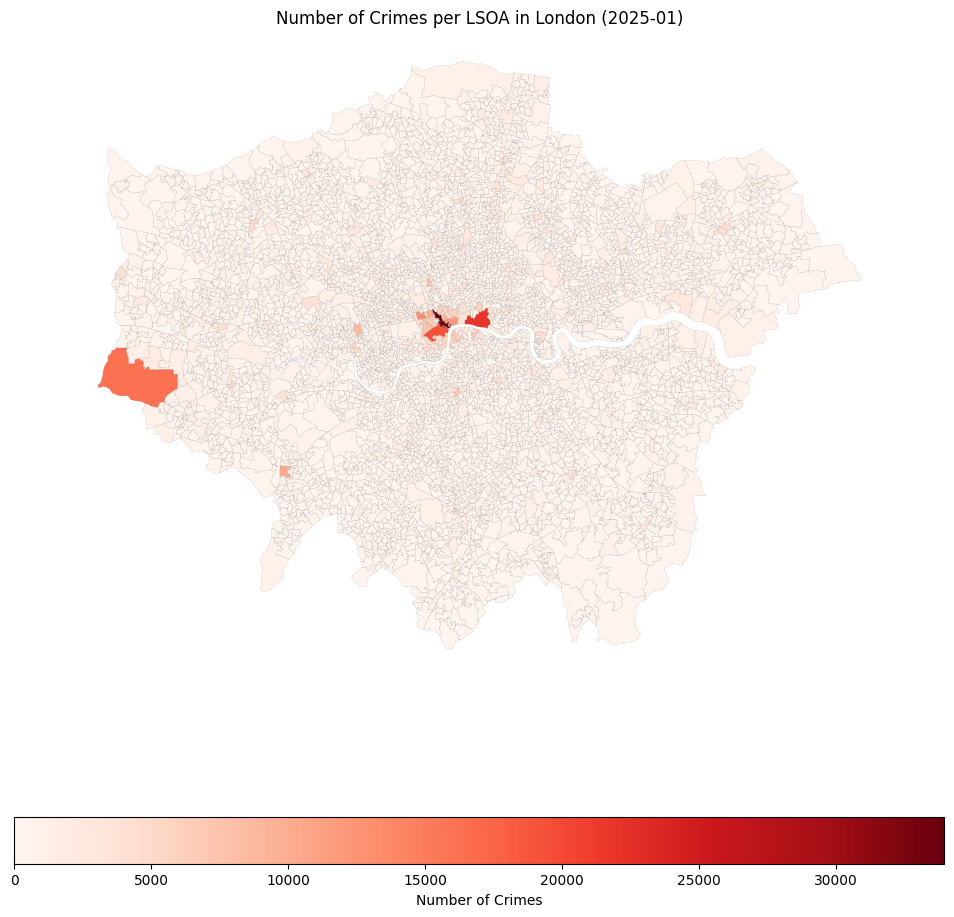

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_gdf.plot(
    column="crime_count",
    cmap="Reds",
    linewidth=0.1,
    ax=ax,
    edgecolor="0.5",
    legend=True,
    legend_kwds={"label": "Number of Crimes", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"}
)
ax.set_title("Number of Crimes per LSOA in London (2025-01)")
ax.axis("off")
plt.show()


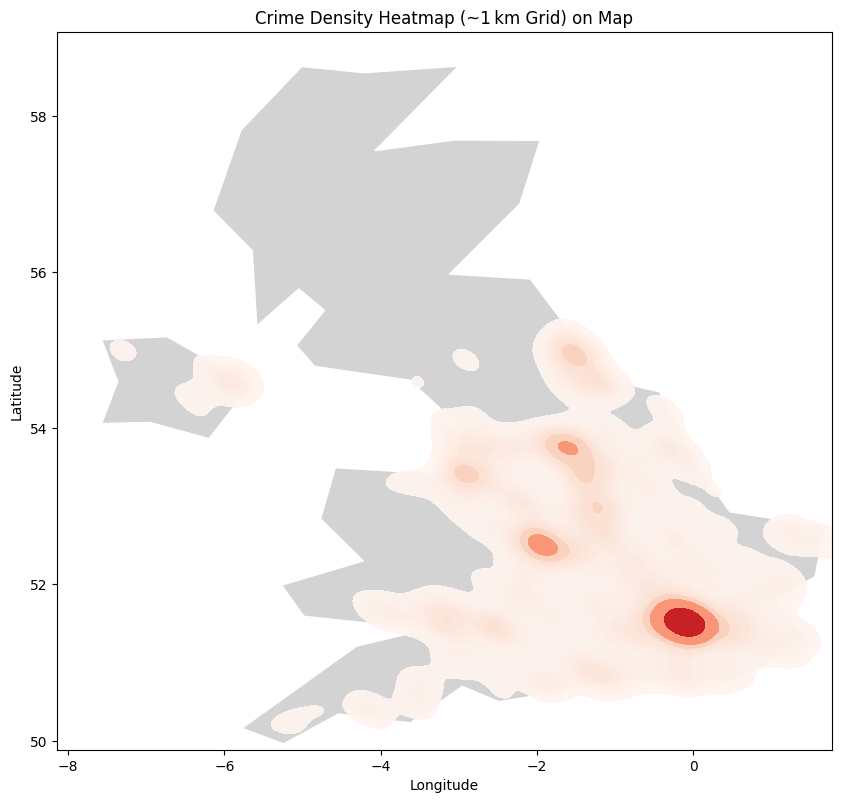

In [32]:
# Create spatial bins
grid_size = 0.01  # ~1 km grid

df_binned = df.withColumn("lat_bin", (F.col("latitude")/grid_size).cast("int")) \
              .withColumn("lon_bin", (F.col("longitude")/grid_size).cast("int"))

# Count crimes per grid cell
grid_counts_df = (
    df_binned.groupBy("lat_bin", "lon_bin")
             .agg(F.count("*").alias("crime_count"))
             .orderBy(F.desc("crime_count"))
)

# Collect to pandas
grid_counts_pd = grid_counts_df.toPandas()

# Recover approximate central coordinates for plotting
grid_counts_pd["lat_center"] = (grid_counts_pd["lat_bin"] + 0.5) * grid_size
grid_counts_pd["lon_center"] = (grid_counts_pd["lon_bin"] + 0.5) * grid_size

#Plot heatmap overlayed on basemap
geometry = [Point(xy) for xy in zip(grid_counts_pd["lon_center"],
                                   grid_counts_pd["lat_center"])]
gdf_grid = gpd.GeoDataFrame(grid_counts_pd,
                            geometry=geometry,
                            crs="EPSG:4326")


world = gpd.read_file('map/ne_110m_admin_0_countries.dbf')
basemap = world[world["NAME"] == "United Kingdom"]

fig, ax = plt.subplots(figsize=(10, 10))

basemap.to_crs(epsg=4326).plot(ax=ax,
                              color="lightgray",
                              edgecolor="white")


sns.kdeplot(
    x=gdf_grid.geometry.x,
    y=gdf_grid.geometry.y,
    weights=gdf_grid["crime_count"], 
    fill=True,
    cmap="Reds",
    thresh=0.05,
    bw_adjust=0.5,
    alpha=0.95,
    ax=ax,
    clip=(
        (gdf_grid["lon_center"].min() - 0.01,
         gdf_grid["lon_center"].max() + 0.01),
        (gdf_grid["lat_center"].min() - 0.01,
         gdf_grid["lat_center"].max() + 0.01)
    )
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Crime Density Heatmap (~1 km Grid) on Map")
ax.set_aspect("equal")
plt.show()


## Hotspot Analysis

Lets train two different models of two different resolutions:
 - Smaller spatial resolution for full UK
 - Bigger spatial resolution for London only 

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import GBTClassifier

In [28]:
df_subsample = df_clean.sample(fraction=0.8, seed=42)

In [92]:
LONDON_LAT_MIN = 51.28
LONDON_LAT_MAX = 51.70
LONDON_LON_MIN = -0.55
LONDON_LON_MAX = 0.35

UK_LAT_MIN = 49.8   
UK_LAT_MAX = 55.9   
UK_LON_MIN = -6.0   
UK_LON_MAX =  2.0


feature_cols = [
    "lat_bin",
    "lon_bin",
    "month_sin",
    "month_cos",
    "year"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

def preprocess_df(df, grid_size, assembler):
    df_grid = (
        df
        .withColumn("lat_bin", (F.col("latitude") / grid_size).cast("int"))
        .withColumn("lon_bin", (F.col("longitude") / grid_size).cast("int"))
    )

    monthly_grid_df = (
        df_grid
        .groupBy("lat_bin", "lon_bin", "year", "month_num")
        .agg(F.count("*").alias("crime_count"))
    )

    percentile = 0.90
    thresholds = (
        monthly_grid_df
        .groupBy("year", "month_num")
        .agg(F.expr(f"percentile_approx(crime_count, {percentile})").alias("hotspot_threshold"))
    )

    labeled_df = (
        monthly_grid_df
        .join(thresholds, on=["year", "month_num"])
        .withColumn(
            "hotspot",
            (F.col("crime_count") >= F.col("hotspot_threshold")).cast("int")
        )
    )

    features_df = (
        labeled_df
        .withColumn("month_sin", F.sin(2 * 3.14159 * F.col("month_num") / 12))
        .withColumn("month_cos", F.cos(2 * 3.14159 * F.col("month_num") / 12))
        .withColumn("time_index",F.col("year") * 12 + F.col("month_num"))
    )

    final_df = assembler.transform(features_df).select(
        "features", "hotspot", "year", "month_num", "lat_bin", "lon_bin", "time_index"
    )

    return final_df

### Training a model on the full UK

In [61]:
grid_size = 0.01  # ~1km

final_df = preprocess_df(df_subsample, grid_size, assembler)

max_time = final_df.agg(F.max("time_index")).collect()[0][0]

test_horizon = 5
cutoff_time = max_time - test_horizon

train_df = final_df.filter(F.col("time_index") <= cutoff_time).cache()
test_df  = final_df.filter(F.col("time_index") > cutoff_time)

print(train_df.count(), test_df.count())

1089273 180102


In [66]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(
    labelCol="hotspot",
    featuresCol="features",
    maxIter=100,
    maxDepth=6
)

model = gbt.fit(train_df)

predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print(f"AUC (no lags): {auc:.3f}")

26/01/07 13:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
26/01/07 13:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
26/01/07 13:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
26/01/07 13:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
26/01/07 13:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
26/01/07 13:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1010.4 KiB
26/01/07 13:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB
26/01/07 13:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB
26/01/07 13:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
26/01/07 13:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB
26/01/07 13:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1018.2 KiB
26/01/07 13:35:11 WAR

AUC (no lags): 0.811


In [67]:
from pyspark.ml.functions import vector_to_array

pred_scored = predictions.withColumn(
    "p_hotspot",
    vector_to_array(col("probability"))[1]
)

pred_sorted = pred_scored.orderBy(col("p_hotspot").desc())

def precision_at_k(df, k):
    top_k = df.limit(k)
    return top_k.agg({"hotspot": "avg"}).collect()[0][0]

for k in [50, 100, 200]:
    print(f"P@{k} =", precision_at_k(pred_sorted, k))

26/01/07 18:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1336.5 KiB
26/01/07 18:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1312.4 KiB


P@50 = 0.96


26/01/07 18:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1336.5 KiB
26/01/07 18:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1312.4 KiB


P@100 = 0.97


26/01/07 18:04:02 WARN DAGScheduler: Broadcasting large task binary with size 1336.5 KiB


P@200 = 0.945


26/01/07 18:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1312.4 KiB


In [68]:
from pyspark.sql.types import DoubleType

def predict_hotspots_for_area(
    spark,
    model,
    vector_assembler,
    grid_size,
    lat_min,
    lat_max,
    lon_min,
    lon_max,
    year,
    month
):

    # Create latitude / longitude bin ranges
    lat_bins = (
        spark.range(
            int(lat_min / grid_size),
            int(lat_max / grid_size) + 1
        )
        .withColumnRenamed("id", "lat_bin")
    )

    lon_bins = (
        spark.range(
            int(lon_min / grid_size),
            int(lon_max / grid_size) + 1
        )
        .withColumnRenamed("id", "lon_bin")
    )

    # Create full grid (cartesian product)
    grid_df = lat_bins.crossJoin(lon_bins)

    # Add time features
    grid_df = (
        grid_df
        .withColumn("year", F.lit(year))
        .withColumn("month_num", F.lit(month))
        .withColumn(
            "month_sin",
            F.sin(F.lit(2 * 3.14159265 * month / 12))
        )
        .withColumn(
            "month_cos",
            F.cos(F.lit(2 * 3.14159265 * month / 12))
        )
    )

    # 4️⃣ Assemble features
    grid_features = vector_assembler.transform(grid_df)

    # 5️⃣ Predict
    predictions = model.transform(grid_features)

    # 6️⃣ Extract hotspot probability (class = 1)
    extract_prob = F.udf(lambda v: float(v[1]), DoubleType())

    predictions = predictions.withColumn(
        "p_hotspot",
        extract_prob(F.col("probability"))
    )

    # 7️⃣ Convert bins to coordinates (center of cell)
    predictions = (
        predictions
        .withColumn("latitude", (F.col("lat_bin") + 0.5) * grid_size)
        .withColumn("longitude", (F.col("lon_bin") + 0.5) * grid_size)
    )

    return predictions.select(
        "latitude",
        "longitude",
        "lat_bin",
        "lon_bin",
        "p_hotspot"
    )

26/01/07 18:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1269.8 KiB


<Figure size 1000x1000 with 0 Axes>

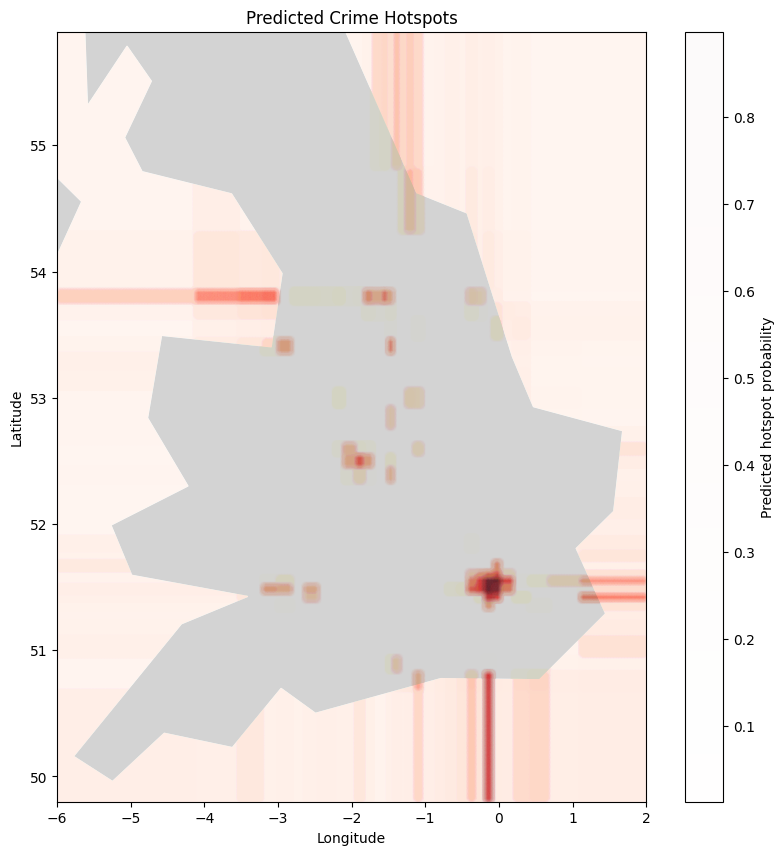

In [78]:
london_preds = predict_hotspots_for_area(
    spark=spark,
    model=model,
    vector_assembler=assembler,
    grid_size=grid_size,
    lat_min=UK_LAT_MIN,
    lat_max=UK_LAT_MAX,
    lon_min=UK_LON_MIN,
    lon_max=UK_LON_MAX,
    year=2025,
    month=7
)

pred_pd = london_preds.toPandas().sort_values("p_hotspot", ascending=False)

plt.figure(figsize=(10, 10))


# geometry = [Point(xy) for xy in zip(grid_counts_pd["lon_center"],
#                                    grid_counts_pd["lat_center"])]
# gdf_grid = gpd.GeoDataFrame(grid_counts_pd,
#                             geometry=geometry,
#                             crs="EPSG:4326")


world = gpd.read_file('map/ne_110m_admin_0_countries.dbf')
basemap = world[world["NAME"] == "United Kingdom"]

fig, ax = plt.subplots(figsize=(10, 10))

basemap.to_crs(epsg=4326).plot(ax=ax,
                              color="lightgray",
                              edgecolor="white")

sc = plt.scatter(
    pred_pd["longitude"],
    pred_pd["latitude"],
    c=pred_pd["p_hotspot"],
    cmap="Reds",
    s=20,
    alpha=0.02
)

plt.colorbar(sc, label="Predicted hotspot probability")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted Crime Hotspots")
plt.xlim(UK_LON_MIN, UK_LON_MAX)
plt.ylim(UK_LAT_MIN, UK_LAT_MAX)

plt.show()

### Hotspot Detection London

In [76]:
LONDON_LAT_MIN = 51.28
LONDON_LAT_MAX = 51.70
LONDON_LON_MIN = -0.55
LONDON_LON_MAX = 0.35

UK_LAT_MIN = 49.8   
UK_LAT_MAX = 55.9   
UK_LON_MIN = -6.0   
UK_LON_MAX =  2.0  

# .filter(
#         (F.col("latitude").between(LONDON_LAT_MIN, LONDON_LAT_MAX)) &
#         (F.col("longitude").between(LONDON_LON_MIN, LONDON_LON_MAX))
#     )

In [90]:
df_subsample.filter(
         (F.col("latitude").between(LONDON_LAT_MIN, LONDON_LAT_MAX)) &
         (F.col("longitude").between(LONDON_LON_MIN, LONDON_LON_MAX))
    ).count()

3039429

In [93]:
grid_size = 0.001  # ~1km

london_df = df_subsample.filter(
         (F.col("latitude").between(LONDON_LAT_MIN, LONDON_LAT_MAX)) &
         (F.col("longitude").between(LONDON_LON_MIN, LONDON_LON_MAX))
    )

final_df = preprocess_df(
    london_df,
    grid_size,
    assembler
)

max_time = final_df.agg(F.max("time_index")).collect()[0][0]

test_horizon = 5
cutoff_time = max_time - test_horizon

train_df = final_df.filter(F.col("time_index") <= cutoff_time).cache()
test_df  = final_df.filter(F.col("time_index") > cutoff_time)

print(train_df.count(), test_df.count())

935821 155837


In [94]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(
    labelCol="hotspot",
    featuresCol="features",
    maxIter=100,
    maxDepth=5
)

model = gbt.fit(train_df)

predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print(f"AUC (no lags): {auc:.3f}")

AUC (no lags): 0.716


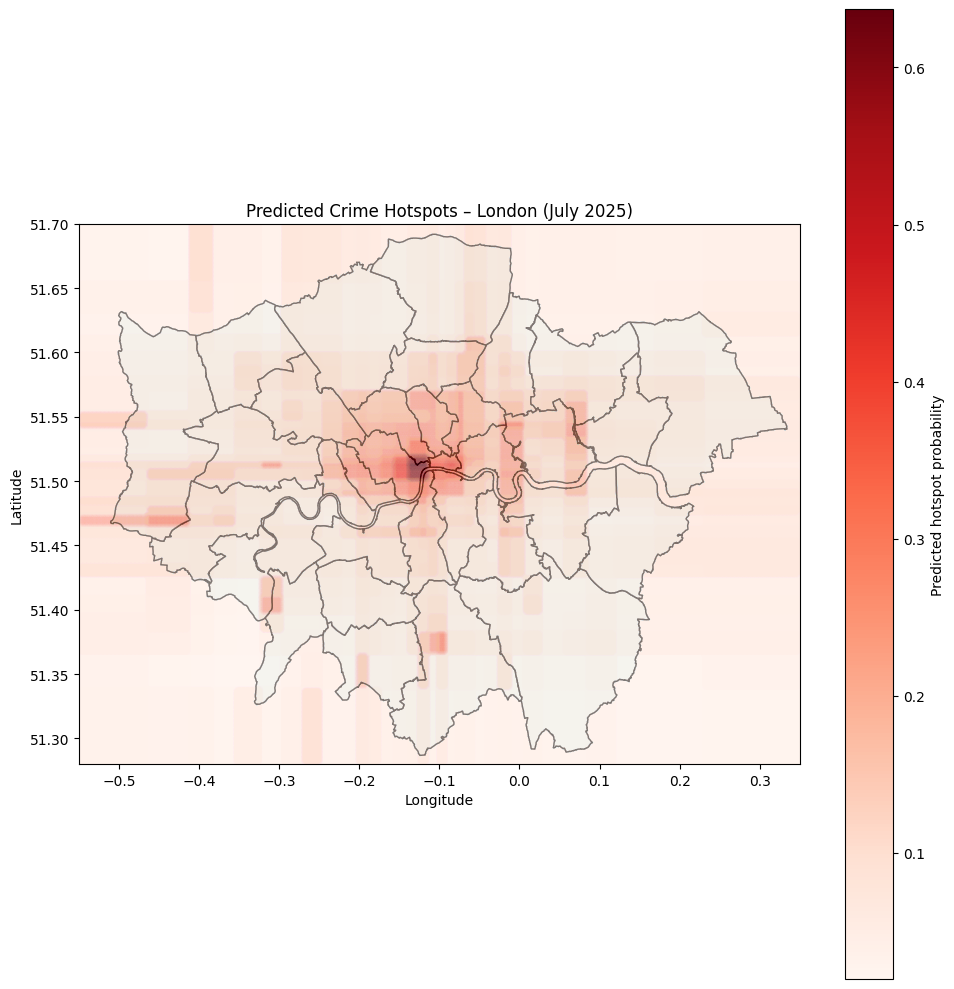

In [96]:
import geopandas as gpd
from shapely.geometry import Point

london_preds = predict_hotspots_for_area(
    spark=spark,
    model=model,
    vector_assembler=assembler,
    grid_size=grid_size,
    lat_min=LONDON_LAT_MIN,
    lat_max=LONDON_LAT_MAX,
    lon_min=LONDON_LON_MIN,
    lon_max=LONDON_LON_MAX,
    year=2025,
    month=7
)

pred_pd = london_preds.toPandas().sort_values("p_hotspot", ascending=False)


# Convert predictions to GeoDataFrame
gdf_preds = gpd.GeoDataFrame(
    pred_pd,
    geometry=gpd.points_from_xy(pred_pd.longitude, pred_pd.latitude),
    crs="EPSG:4326"  # WGS84
)


london_map = gpd.read_file("London_Borough_Excluding_MHW.shp").set_crs("EPSG:27700").to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot base map
london_map.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="black"
)

# Plot predicted hotspots
gdf_preds.plot(
    ax=ax,
    column="p_hotspot",
    cmap="Reds",
    markersize=15,
    alpha=0.02,
    legend=True,
    legend_kwds={"label": "Predicted hotspot probability"}
)

# Zoom to London
ax.set_xlim(LONDON_LON_MIN, LONDON_LON_MAX)
ax.set_ylim(LONDON_LAT_MIN, LONDON_LAT_MAX)

ax.set_title("Predicted Crime Hotspots – London (July 2025)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

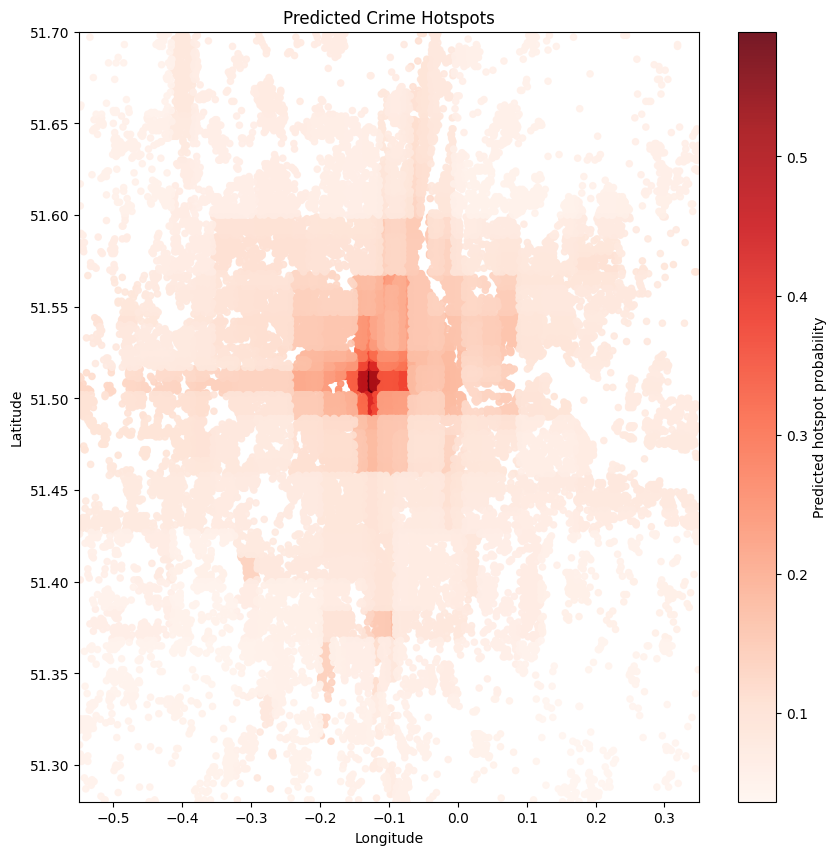

In [50]:
pred_pd = pred_scored.filter(F.col("year") == 2025).filter(F.col("month_num") == 8).select(
    "lat_bin", "lon_bin", "p_hotspot"
).toPandas().sort_values("p_hotspot", ascending=False)

BIN_SIZE = 0.001

pred_pd["lat"] = pred_pd["lat_bin"] * BIN_SIZE
pred_pd["lon"] = pred_pd["lon_bin"] * BIN_SIZE

plt.figure(figsize=(10, 10))

sc = plt.scatter(
    pred_pd["lon"],
    pred_pd["lat"],
    c=pred_pd["p_hotspot"],
    cmap="Reds",
    s=20,
    alpha=0.9
)

plt.colorbar(sc, label="Predicted hotspot probability")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted Crime Hotspots")
plt.xlim(LONDON_LON_MIN, LONDON_LON_MAX)
plt.ylim(LONDON_LAT_MIN, LONDON_LAT_MAX)

plt.show()